In [1]:
import itertools
import time
from collections import OrderedDict
from datetime import timedelta as td
from typing import (Any, Callable, Dict, Iterator, List, Optional, Tuple, Type,
                    Union, cast)

import numpy as np

import torch
import torch.nn as nn



from dgt.helper import ScaleBinarizer1, Sparser1, XLinear

"""
The Regression supported in this version of DGT is state independent (single theta parameter).
Here, we modify the default regression with linear controller which is state dependent
Args:
- learnable_and_bias: If True, bias in AND layer is learnt otherwise fixed to -counts[1]+eps
    and threshold*height is added later but before activation
- learnable_or_bias: Bias in the OR layer is same for all neurons by default but if this is set to True,
    the bias is learnt otherwise it is set to 0 (for all neurons).

Notes:
    In the AND layer for every neuron this is what happens:
    - When learnable_and_bias=False
        - ReLU(w.x - counts[1] + eps + threshold*height)
        - w is also fixed to {-1, 0, 1}
        - -counts[1] + eps is the fixed bias in XLinear, threshold*height is added in forward()
    - When learnable_and_bias=True
        - ReLU(w.x + b + height*threshold)
        - w is fixed, b is learnt
"""

'\nThe Regression supported in this version of DGT is state independent (single theta parameter).\nHere, we modify the default regression with linear controller which is state dependent\nArgs:\n- learnable_and_bias: If True, bias in AND layer is learnt otherwise fixed to -counts[1]+eps\n    and threshold*height is added later but before activation\n- learnable_or_bias: Bias in the OR layer is same for all neurons by default but if this is set to True,\n    the bias is learnt otherwise it is set to 0 (for all neurons).\n\nNotes:\n    In the AND layer for every neuron this is what happens:\n    - When learnable_and_bias=False\n        - ReLU(w.x - counts[1] + eps + threshold*height)\n        - w is also fixed to {-1, 0, 1}\n        - -counts[1] + eps is the fixed bias in XLinear, threshold*height is added in forward()\n    - When learnable_and_bias=True\n        - ReLU(w.x + b + height*threshold)\n        - w is fixed, b is learnt\n'

In [44]:
class DGT(nn.Module):
    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        height: int,
        is_regression: bool = True,
    ):
        super().__init__()

        self._height = height # 63 internal nodes

        self._and_act_fn = torch.nn.Softmax(dim=-1)
        self._fp_type = torch.float32

        self._over_param = [] # [16, 16] # SPP: No overparametrization since DTSemNet also doesn't have it

        self.in_dim = in_dim
        self.out_dim = out_dim
        self.is_regression = is_regression
        int_nodes = 2 ** height - 1 # SPP: define internal nodes
        leaf_nodes = 2 ** height

        

        ########### L1 ##########
        if len(self._over_param)==0:
            self._predicate_l = nn.Linear(in_dim, int_nodes)
            if True:
                with torch.no_grad(): nn.init.zeros_(self._predicate_l.bias)
            self._predicate_l = nn.Sequential(self._predicate_l)
        else:
            self._predicate_l = []
            mid_nodes = [int(x*int_nodes) for x in self._over_param]
            self._predicate_l = [nn.Linear(a,b) for a,b in zip([in_dim]+mid_nodes, mid_nodes+[int_nodes])]
            if True:
                with torch.no_grad():
                    [nn.init.zeros_(x.bias) for x in self._predicate_l if isinstance(x, nn.Linear)]
            self._predicate_l = nn.Sequential(*self._predicate_l)

        # orthogonal initialization of self._predicate_l all layer
        # For Fair Comparison
        for module in self._predicate_l.modules():
            if isinstance(module, nn.Linear):
                nn.init.orthogonal_(module.weight)


        ########### L2 ##########
        weight, fixed_bias = DGT._get_and_layer_params(height, self._fp_type)
        # fixed_bias is now 0 not -h # SPP: ok
        # SPP: But I don't get why we need a bias term instead of 'h'.
        self._and_l = XLinear(int_nodes, leaf_nodes, weight=weight, bias=None, same=False)

        ########### L3 ##########
        self._or_l = nn.ModuleList()

        # Add as many controllers as the number of output classes
        for i in range(out_dim):
            linear_layer = nn.Linear(in_features=leaf_nodes, out_features=in_dim, bias=True)
            nn.init.xavier_uniform_(linear_layer.weight)
            self._or_l.append(linear_layer)
            
        ########### L4 ########## Regression with linear controller


        self.action_stds = nn.Parameter(torch.randn(leaf_nodes, 2), requires_grad=True)
        torch.nn.init.xavier_uniform_(self.action_stds)


    def get_parameters_set(self, set_idx: int) -> Iterator[nn.Parameter]:
        if set_idx == 1:
            vals = [self._predicate_l.parameters()]

            return itertools.chain(*vals)

        elif set_idx == 2:
            return self._or_l.parameters()

        else:
            raise ValueError(f'{set_idx} must be in [1, 2]')

    def forward(
        self,
        x: torch.Tensor,
    ) -> torch.Tensor: # type: ignore


        ########### L1 ##########
        pred_z = self._predicate_l(x)

        pred_a, fac = ScaleBinarizer1.apply(pred_z) ; fac = fac.detach()
        pred_a = 2*pred_a - fac


        print(pred_a ,pred_a.shape)
        ########### L2 ##########
        and_z_a = self._and_l(pred_a)
        and_a = self._and_act_fn(and_z_a)
        and_a = Sparser1.apply(and_a)

        print("and_op", and_a ,and_a.shape)
        ########### L3 ##########
        final = []
        for i in range(self.out_dim):
            wt = self._or_l[i](and_a)
            print('wt',wt ,wt.shape)
            out = torch.sum(wt * x, dim=1)
            print(out)
            final.append(out)
        out = torch.stack(final, dim=1)
        
        # squeeze the last dimension
        print("out",out ,out.shape)
        # compute std
        # Mask the action_stds based on and_a
        print(self.action_stds)
        detached_and_a = and_a.detach()
        detached_and_a.requires_grad = False

        print('std_actions', self.action_stds)
        masked_action_stds = self.action_stds * detached_and_a.unsqueeze(2)
        # Sum along the num_leaf dimension
        print('masked_stds', masked_action_stds)
        std = masked_action_stds.sum(dim=1)
        print("std",std)
        std = std.sum(dim=-1).reshape(-1, 1)
        std = torch.clamp(std, min=-20, max=2)
        print("std", std ,std.shape)


        # need to return mean and std    
        return out, std

    @staticmethod
    def _get_and_layer_params(height: int, fp_type) -> Tuple[torch.Tensor, torch.Tensor]:
        int_nodes = 2 ** height - 1
        leaf_nodes = 2 ** height

        weight = np.zeros((leaf_nodes, int_nodes))

        # Fill in the weight matrix level by level
        # i represents the level of nodes which we are handling at a given iteration
        for i in range(height):
            # Number of nodes in this level
            num_nodes = 2 ** i
            # Start number of node in this level
            start = 2 ** i - 1

            # Iterate through all nodes at this level
            for j in range(start, start + num_nodes):
                row_begin = (leaf_nodes // num_nodes) * (j - start)
                row_mid = row_begin + (leaf_nodes // (2 * num_nodes))
                row_end = row_begin + (leaf_nodes // num_nodes)

                weight[row_begin: row_mid, j] = 1
                weight[row_mid: row_end, j] = -1

        fixed_bias = torch.zeros(size=(2 ** height,), dtype=fp_type)

        return torch.from_numpy(weight).to(fp_type), fixed_bias


In [45]:
dt = DGT(in_dim=5, out_dim=2, height=4)

In [46]:
sample = torch.tensor([[-0.0340,  3.2220,  0.1739, -2.4158,  1.6808],
                       ])

In [47]:
sample

tensor([[-0.0340,  3.2220,  0.1739, -2.4158,  1.6808]])

In [48]:
output = dt(sample)

tensor([[ 0.8959,  0.8959,  0.8959, -0.8959, -0.8959, -0.8959, -0.8959,  0.8959,
          0.8959, -0.8959,  0.8959, -0.8959, -0.8959,  0.8959,  0.8959]],
       grad_fn=<SubBackward0>) torch.Size([1, 15])
and_op tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       grad_fn=<Sparser1Backward>) torch.Size([1, 16])
wt tensor([[-0.1885, -0.5931,  0.4447, -0.2060, -0.4713]],
       grad_fn=<AddmmBackward0>) torch.Size([1, 5])
tensor([-2.1217], grad_fn=<SumBackward1>)
wt tensor([[-0.1048, -0.5189, -0.1408, -0.2544,  0.3653]],
       grad_fn=<AddmmBackward0>) torch.Size([1, 5])
tensor([-0.4643], grad_fn=<SumBackward1>)
out tensor([[-2.1217, -0.4643]], grad_fn=<StackBackward0>) torch.Size([1, 2])
Parameter containing:
tensor([[-0.1302, -0.0923],
        [-0.2232, -0.5178],
        [-0.3150, -0.1810],
        [-0.2301,  0.3801],
        [-0.5414,  0.4578],
        [ 0.2642, -0.1790],
        [-0.5227, -0.2041],
        [ 0.5319,  0.4501],
        [ 0.3145, -0.3920],

In [49]:
# dot product of two vectors
torch.dot(torch.tensor([-0.2892, -0.4206, -0.1391, -0.1743, -0.4671]), torch.tensor([-0.0340,  3.2220,  0.1739, -2.4158,  1.6808]))

tensor(-1.7336)

In [50]:
from torchviz import make_dot
from graphviz import Digraph

In [51]:
output

(tensor([[-2.1217, -0.4643]], grad_fn=<StackBackward0>),
 tensor([[-0.4960]], grad_fn=<ClampBackward1>))

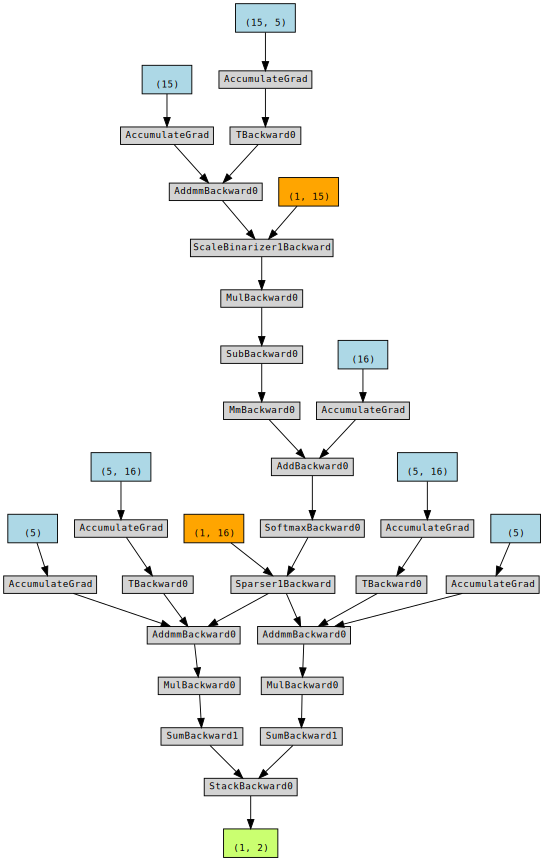

In [52]:
make_dot(output[0])

In [41]:
# output_tensor_m, output_tensor_std  = dt(sample)

# # Calculate gradients
# output_tensor_m.sum().backward()
# # output_tensor_std.sum().backward()

# # Visualize the network with gradient flow
# dot = make_dot(output_tensor_m, params=dict(dt.named_parameters()))
# # dot2 = make_dot(output_tensor_std, params=dict(dt.named_parameters()))
# dot.render("network_graph_mean", format="png")
# # dot2.render("network_graph_std", format="png")

## check weights are updated in training

In [58]:
import torch.optim as optim

# Step 1: Define a loss function
loss_fn = nn.MSELoss()

# Step 2: Create an optimizer
optimizer = optim.SGD(dt.parameters(), lr=0.1)

num_samples = 20
# Step 3: Generate a random sample
sample = torch.randn(num_samples, 5)

# Step 7: Check the model parameters before and after training
print("Model parameters before training:")
for name, param in dt.named_parameters():
    print(name, param.data)

# Step 4: Compute the output of the model for the sample
output = dt(sample)

# Step 5: Compute the loss between the model output and the target
target = torch.randn(num_samples, 2)
loss = loss_fn(output[0], target)

# Step 6: Backpropagate the gradients and update the model parameters
optimizer.zero_grad()
loss.backward()
optimizer.step()

print("\nModel parameters after training:")
for name, param in dt.named_parameters():
    print(name, param.data)


Model parameters before training:
action_stds tensor([[-0.1302, -0.0923],
        [-0.2232, -0.5178],
        [-0.3150, -0.1810],
        [-0.2301,  0.3801],
        [-0.5414,  0.4578],
        [ 0.2642, -0.1790],
        [-0.5227, -0.2041],
        [ 0.5319,  0.4501],
        [ 0.3145, -0.3920],
        [-0.1498, -0.0137],
        [-0.1666, -0.4893],
        [-0.5753,  0.1345],
        [ 0.4451, -0.3946],
        [ 0.2085, -0.1192],
        [-0.2113,  0.1310],
        [ 0.0687,  0.3855]])
_predicate_l.0.weight tensor([[ 1.8157e-02, -1.5893e-01, -4.6631e-01, -5.6283e-02,  3.5649e-01],
        [ 1.4137e-01,  1.2513e-01, -1.2495e-01, -1.4800e-02, -7.5156e-02],
        [-1.5013e-01, -1.7543e-01, -4.1874e-01, -3.7708e-01,  3.5387e-02],
        [-6.3237e-01, -1.4303e-01, -6.3034e-03,  3.8281e-02, -3.2626e-01],
        [-8.1749e-02, -9.7026e-02, -1.6753e-01,  5.1707e-01, -2.5654e-01],
        [ 1.9508e-01, -2.1110e-02, -9.1824e-02,  1.3553e-01, -2.9885e-02],
        [-2.0986e-02, -1.8423e-01

In [54]:
# print all parameters in 'dt' and check gradient is true or false
for name, param in dt.named_parameters():
    print(name, param.requires_grad)


action_stds True
_predicate_l.0.weight True
_predicate_l.0.bias True
_and_l._bias True
_and_l._l.weight False
_or_l.0.weight True
_or_l.0.bias True
_or_l.1.weight True
_or_l.1.bias True
